# **Import Libraries**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Cleaning & defining**

In [6]:
# reading file

df = pd.read_csv("weather_dataset.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191680 entries, 0 to 2191679
Data columns (total 4 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   location_id               int64  
 1   time                      object 
 2   temperature_2m (°C)       float64
 3   relative_humidity_2m (%)  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 66.9+ MB


In [4]:
# data cleaning

df["time"] = pd.to_datetime(df["time"])  # زمان به datetime
df["location_id"] = df["location_id"].astype("category")  # دسته‌ای
df["relative_humidity_2m (%)"] = df["relative_humidity_2m (%)"].astype("float32")
df["temperature_2m (°C)"] = df["temperature_2m (°C)"].astype("float32")

In [5]:
# definning the season

def get_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["time"].dt.month.map(get_season)

In [6]:
# definning the monthly average

monthly_avr = (
    df.groupby([pd.Grouper(freq="ME", key="time"), "location_id"])
    .mean(numeric_only=True)
    .reset_index()
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\1337938689.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby([pd.Grouper(freq="ME", key="time"), "location_id"])


# **Plot**

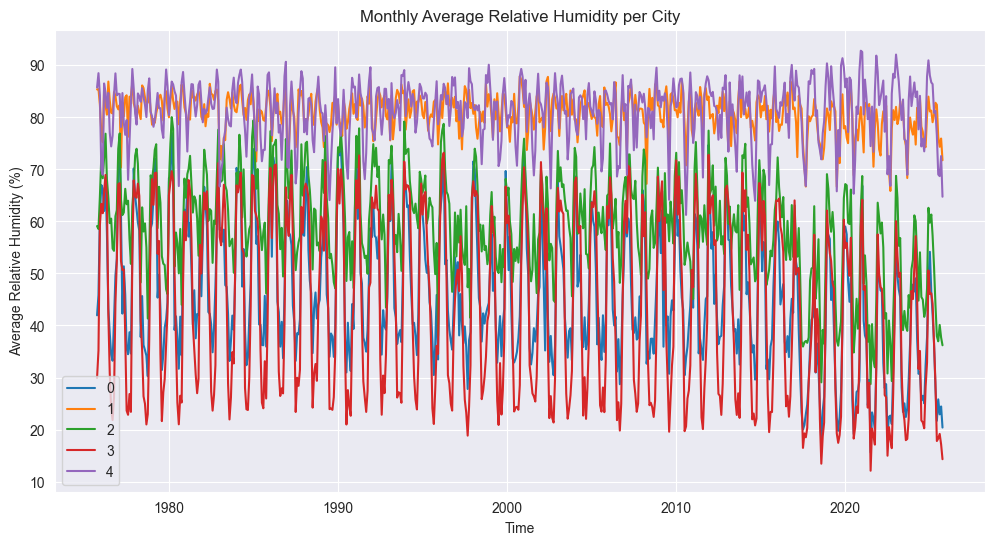

In [8]:
# monthly humidity plot

plt.figure(figsize=(12,6))
for city in monthly_avr["location_id"].unique():
    subset = monthly_avr[monthly_avr["location_id"] == city]
    plt.plot(subset["time"], subset["relative_humidity_2m (%)"], label=city)

plt.xlabel("Time")
plt.ylabel("Average Relative Humidity (%)")
plt.legend()
plt.title("Monthly Average Relative Humidity per City")
plt.show()

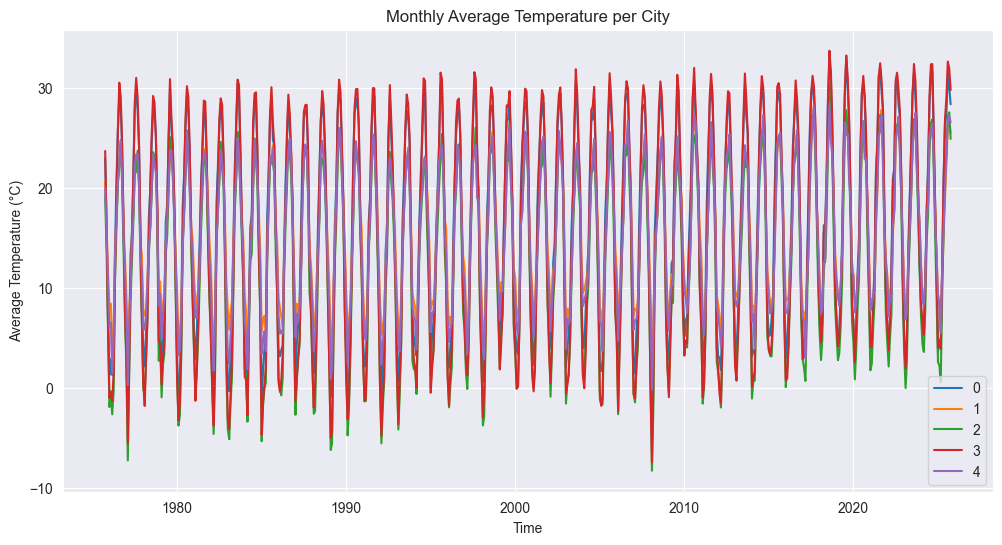

In [9]:
# monthly temperature plot

plt.figure(figsize=(12,6))
for city in monthly_avr["location_id"].unique():
    subset = monthly_avr[monthly_avr["location_id"] == city]
    plt.plot(subset["time"], subset["temperature_2m (°C)"], label=city)

plt.xlabel("Time")
plt.ylabel("Average Temperature (°C)")
plt.legend()
plt.title("Monthly Average Temperature per City")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3868217564.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["location_id", pd.Grouper(key="time", freq="D")])["temperature_2m (°C)"]


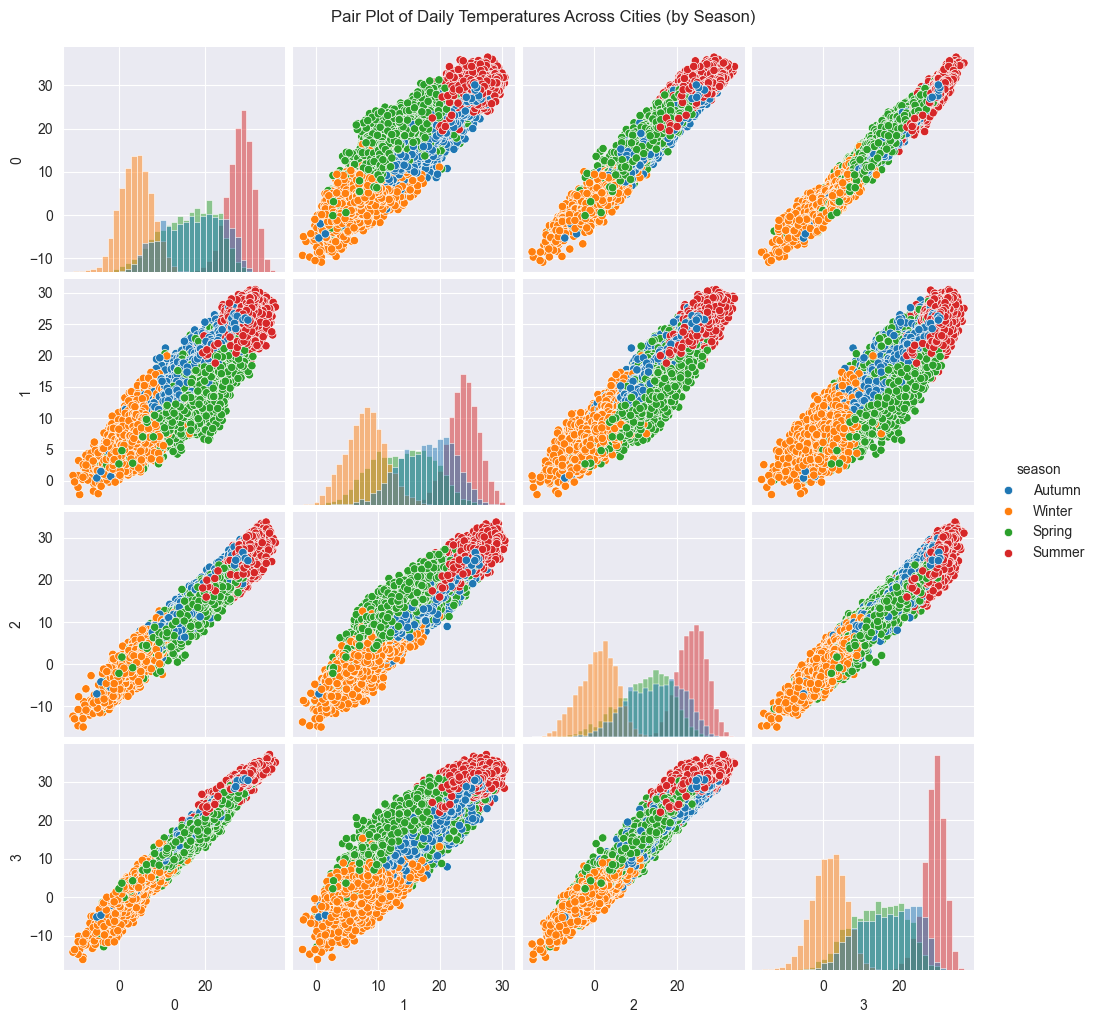

In [10]:
#daily temperature pairplot

daily_temp = (
    df.groupby(["location_id", pd.Grouper(key="time", freq="D")])["temperature_2m (°C)"]
    .mean()
    .reset_index()
)

pivot_temp = daily_temp.pivot(index="time", columns="location_id", values="temperature_2m (°C)")
pivot_temp["season"] = pivot_temp.index.month.map(get_season)

sample_cities = pivot_temp.columns[:-1][:4]
df_plot = pivot_temp[sample_cities.tolist() + ["season"]].dropna()

sns.pairplot(df_plot, hue="season", diag_kind="hist")
plt.suptitle("Pair Plot of Daily Temperatures Across Cities (by Season)", y=1.02)
plt.show()

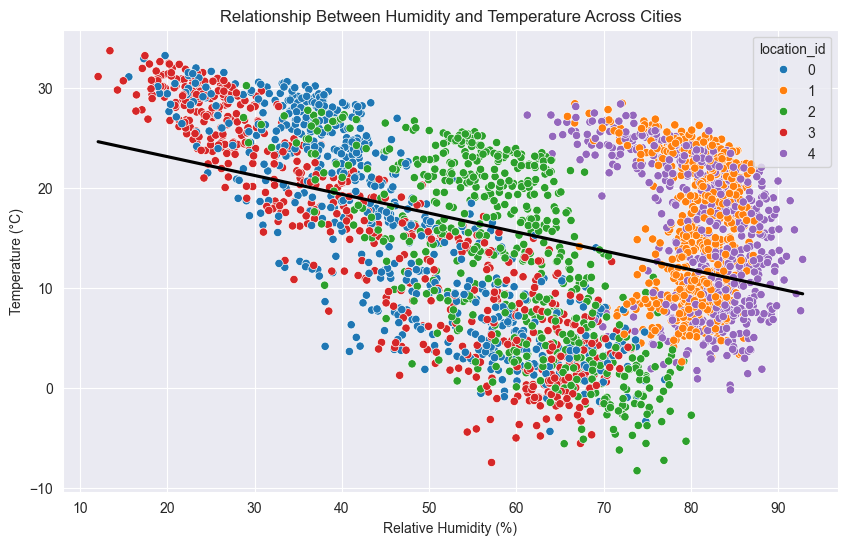

In [12]:
#corralation scatter plot between temp & hum

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=monthly_avr,
    x="relative_humidity_2m (%)",
    y="temperature_2m (°C)",
    hue="location_id"
)
sns.regplot(
    data=monthly_avr,
    x="relative_humidity_2m (%)",
    y="temperature_2m (°C)",
    scatter=False,
    ci=None,
    color="black"
)
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")
plt.title("Relationship Between Humidity and Temperature Across Cities")
plt.show()

In [13]:
#correlation between temp and hum for each city

corrs = (
    monthly_avr.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]]
    .corr()
    .iloc[0::2,-1]
    .reset_index(level=0)
    .rename(columns={"relative_humidity_2m (%)": "corr_temp_humidity"})
)

print("correlation between temp and hum in each city:")
print(corrs)

correlation between temp and hum in each city:
                    location_id  corr_temp_humidity
temperature_2m (°C)           0           -0.842436
temperature_2m (°C)           1           -0.000681
temperature_2m (°C)           2           -0.695562
temperature_2m (°C)           3           -0.926716
temperature_2m (°C)           4           -0.412500


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3303961672.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avr.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3756492004.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  corr_matrix = monthly_avr.pivot_table(


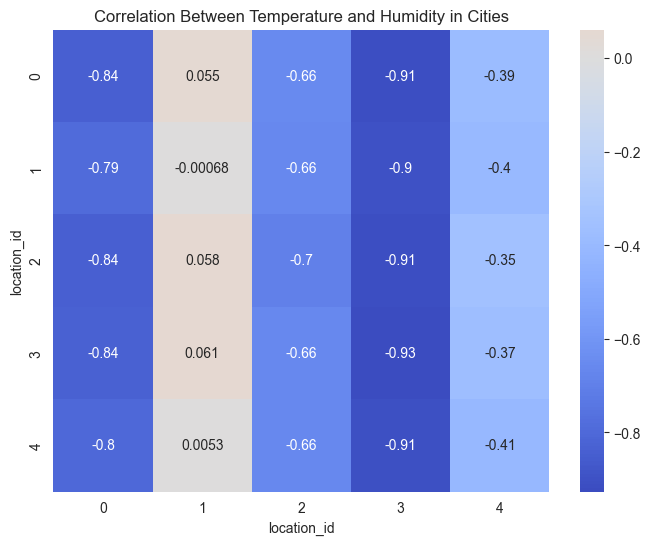

In [14]:
#correlation between temp and hum on heatmap

corr_matrix = monthly_avr.pivot_table(
    index="time",
    columns="location_id",
    values=["temperature_2m (°C)","relative_humidity_2m (%)"]
).corr()

temp_humidity_corr = corr_matrix.loc["temperature_2m (°C)"].xs("relative_humidity_2m (%)", level=0, axis=1)

plt.figure(figsize=(8,6))
sns.heatmap(temp_humidity_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Temperature and Humidity in Cities")
plt.show()


In [15]:
#convert to datetime

df["time"] = pd.to_datetime(df["time"])
df["year"] = df["time"].dt.year
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["hour"] = df["time"].dt.hour

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\1273959828.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_avr = df.groupby(["year","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()


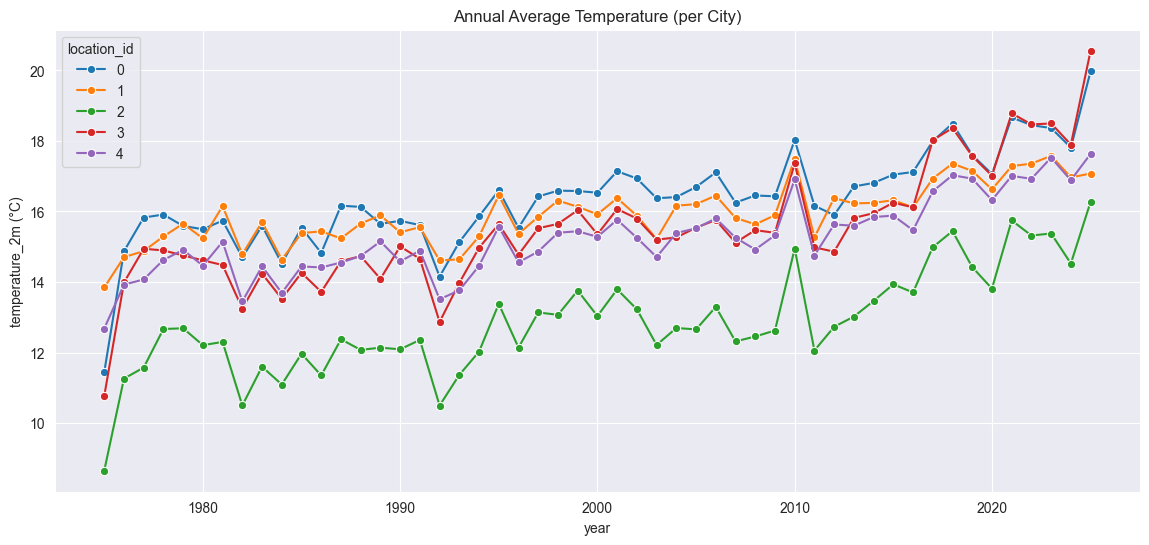

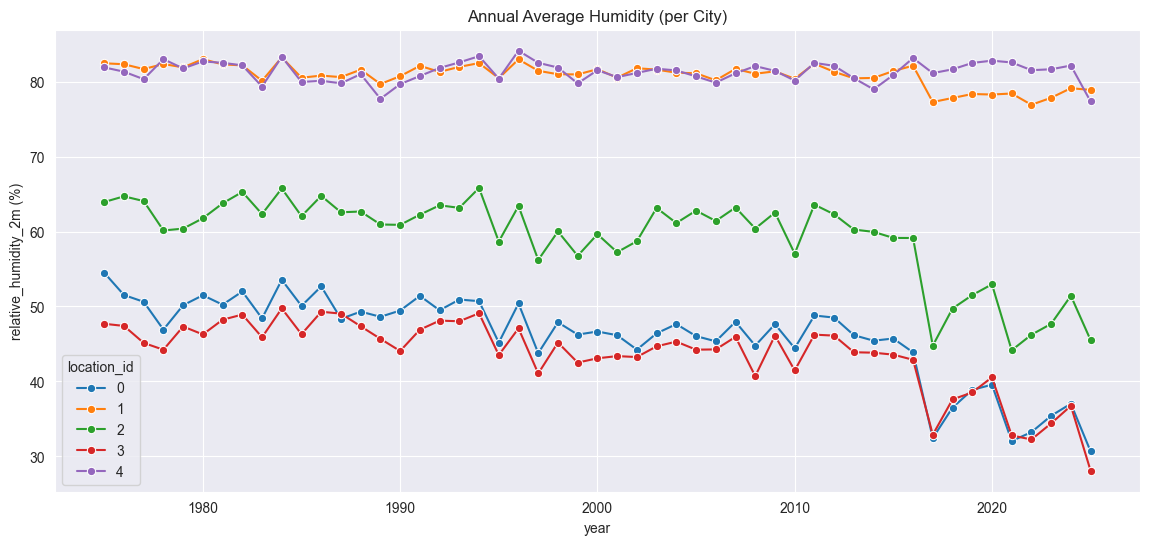

In [16]:

df["season"] = df["month"].map(get_season)

# yearly average and changes in temp and hum

yearly_avr = df.groupby(["year","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_avr, x="year", y="temperature_2m (°C)", hue="location_id", marker="o")
plt.title("Annual Average Temperature (per City)")
plt.show()

plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_avr, x="year", y="relative_humidity_2m (%)", hue="location_id", marker="o")
plt.title("Annual Average Humidity (per City)")
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3475313884.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal = df.groupby(["season","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].agg(["mean","max","min"]).reset_index()


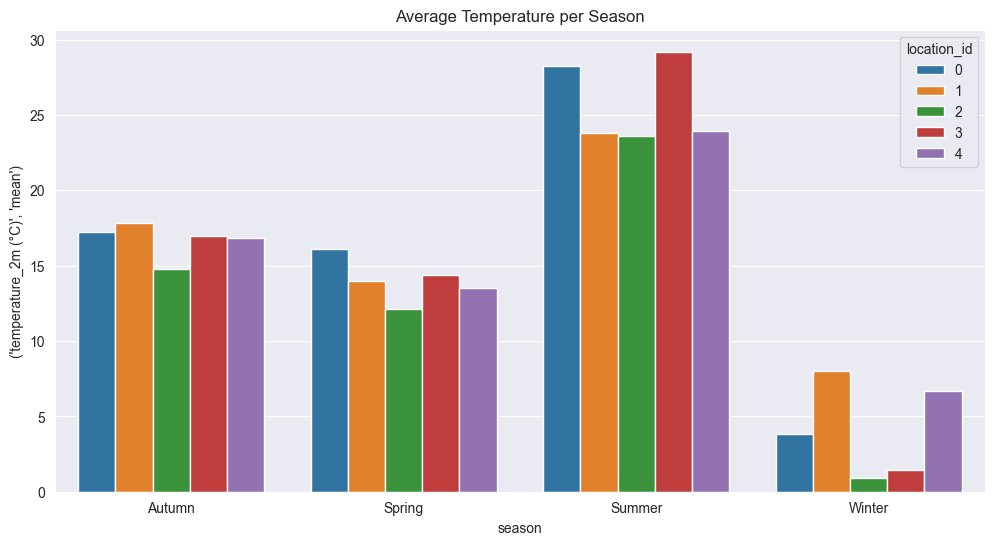

In [17]:
#seasonly comparing

seasonal = df.groupby(["season","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].agg(["mean","max","min"]).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=seasonal, x="season", y=("temperature_2m (°C)","mean"), hue="location_id")
plt.title("Average Temperature per Season")
plt.show()

In [18]:
#day that have a extreme data
extreme_days = df[(df["temperature_2m (°C)"]>40) | (df["relative_humidity_2m (%)"]>90)]
print("day that have a extreme data :", extreme_days.groupby("location_id").size())

day that have a extreme data : location_id
0      3555
1     78277
2     44530
3      5660
4    154300
dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3918470181.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("day that have a extreme data :", extreme_days.groupby("location_id").size())


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3123449450.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diurnal = df.groupby(["hour","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()


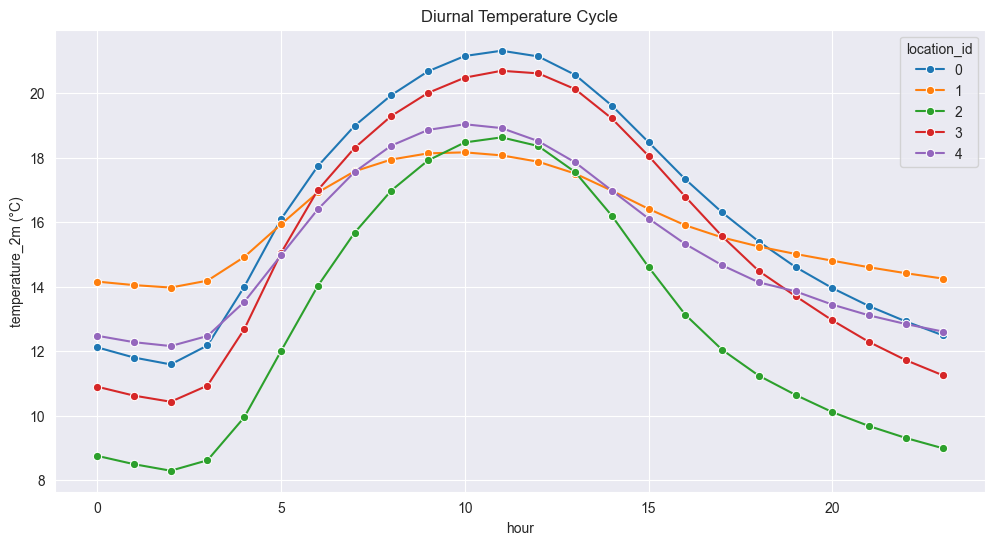

In [19]:
#daily cycle

diurnal = df.groupby(["hour","location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=diurnal, x="hour", y="temperature_2m (°C)", hue="location_id", marker="o")
plt.title("Diurnal Temperature Cycle")
plt.show()

In [20]:
#temp & hum corralation

corrs = df.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]].corr().iloc[0::2,-1]
print("temp & hum corralation:")
print(corrs)

temp & hum corralation:
location_id                     
0            temperature_2m (°C)   -0.696440
1            temperature_2m (°C)   -0.221045
2            temperature_2m (°C)   -0.585783
3            temperature_2m (°C)   -0.799855
4            temperature_2m (°C)   -0.414347
Name: relative_humidity_2m (%), dtype: float64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\4131265007.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corrs = df.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]].corr().iloc[0::2,-1]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\2951798148.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avr = df.groupby([pd.Grouper(freq="M", key="time"), "location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\2951798148.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_avr = df.groupby([pd.Grouper(freq="M", key="time"), "location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\2951798148.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to sile

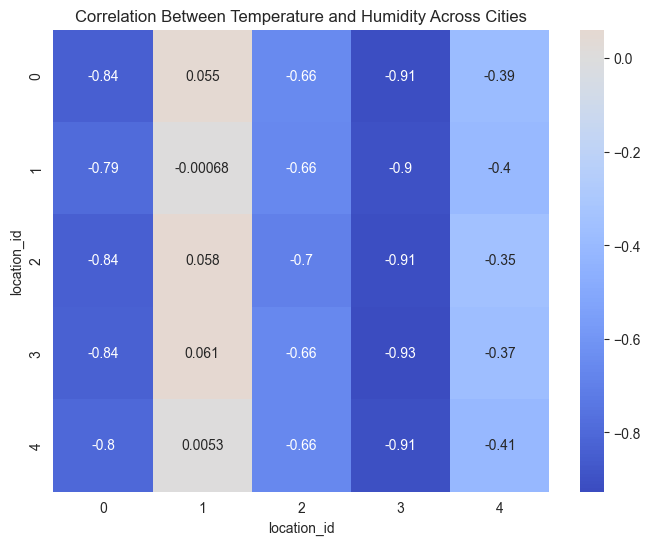

In [21]:
#compare city on heatmap

monthly_avr = df.groupby([pd.Grouper(freq="M", key="time"), "location_id"])[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean().reset_index()

corr_matrix = monthly_avr.pivot_table(index="time", columns="location_id", values=["temperature_2m (°C)","relative_humidity_2m (%)"]).corr()
temp_humidity_corr = corr_matrix.loc["temperature_2m (°C)"].xs("relative_humidity_2m (%)", level=0, axis=1)

plt.figure(figsize=(8,6))
sns.heatmap(temp_humidity_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Temperature and Humidity Across Cities")
plt.show()

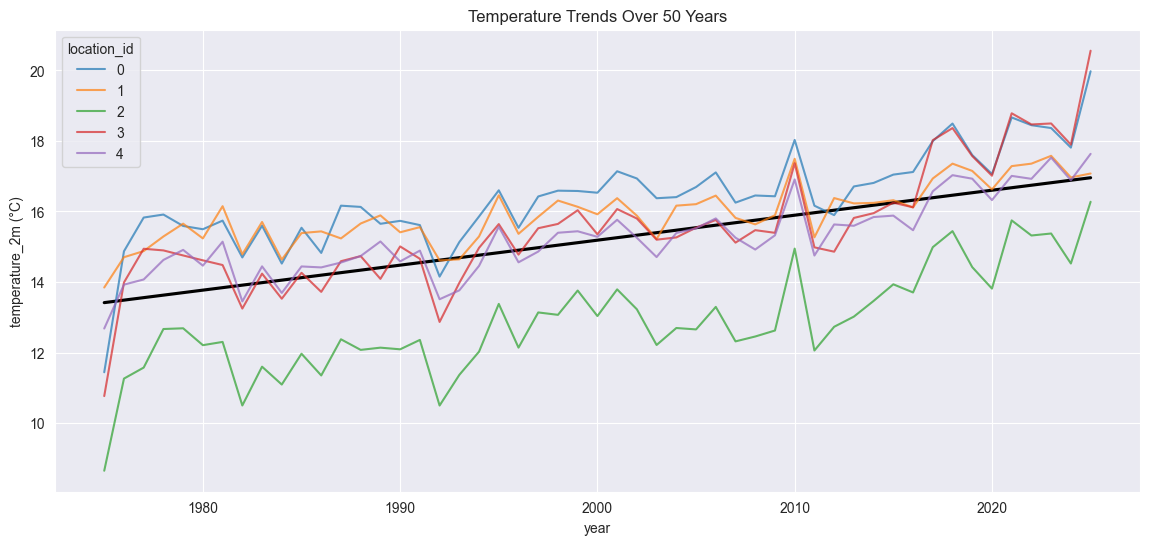

In [22]:
#compere city on trend plot
plt.figure(figsize=(14,6))
sns.regplot(data=yearly_avr, x="year", y="temperature_2m (°C)", scatter=False, ci=None, color="black")
sns.lineplot(data=yearly_avr, x="year", y="temperature_2m (°C)", hue="location_id", alpha=0.7)
plt.title("Temperature Trends Over 50 Years")
plt.show()

In [23]:
# 8. Heatwave Detection

daily_temp = df.groupby(["location_id", pd.Grouper(key="time", freq="D")])["temperature_2m (°C)"].mean().reset_index()
daily_temp["heatwave"] = daily_temp["temperature_2m (°C)"] > 35
daily_temp["year"] = daily_temp["time"].dt.year

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\3990401329.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_temp = df.groupby(["location_id", pd.Grouper(key="time", freq="D")])["temperature_2m (°C)"].mean().reset_index()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\1210351264.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatwave_counts = daily_temp.groupby(["year","location_id"])["heatwave"].sum().reset_index()


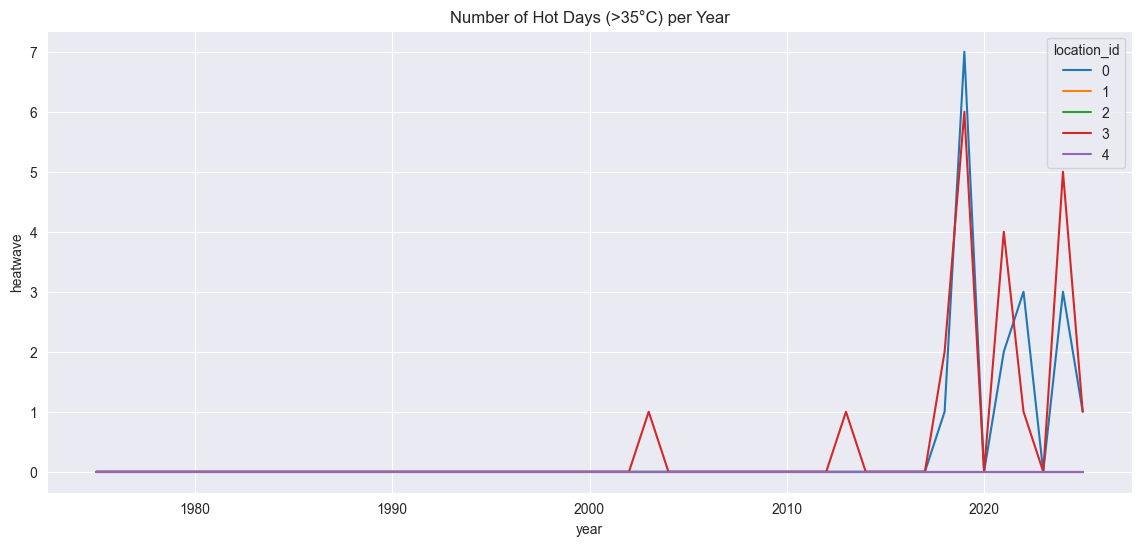

In [24]:
# the day that have 35 degrees plus temp

heatwave_counts = daily_temp.groupby(["year","location_id"])["heatwave"].sum().reset_index()
plt.figure(figsize=(14,6))
sns.lineplot(data=heatwave_counts, x="year", y="heatwave", hue="location_id")
plt.title("Number of Hot Days (>35°C) per Year")
plt.show()

In [25]:

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

city_features = yearly_avr.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean()
scaled = StandardScaler().fit_transform(city_features)
kmeans = KMeans(n_clusters=2, random_state=42).fit(scaled)
city_features["cluster"] = kmeans.labels_
print("grouped city:")
print(city_features)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25316\660653508.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  city_features = yearly_avr.groupby("location_id")[["temperature_2m (°C)","relative_humidity_2m (%)"]].mean()


grouped city:
             temperature_2m (°C)  relative_humidity_2m (%)  cluster
location_id                                                        
0                      16.366537                 45.990154        1
1                      15.921750                 80.852913        0
2                      12.869201                 59.238750        1
3                      15.517614                 43.663017        1
4                      15.251612                 81.307610        0


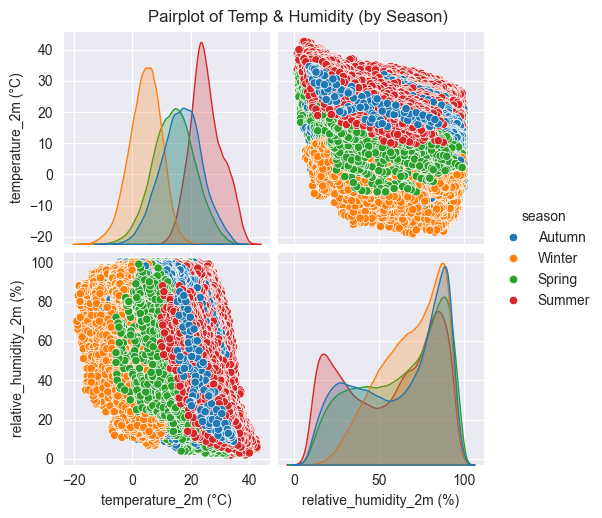

In [26]:
#city pair plot

sample_cities = df["location_id"].unique()[:3]
df_sample = df[df["location_id"].isin(sample_cities)]
sns.pairplot(df_sample, vars=["temperature_2m (°C)","relative_humidity_2m (%)"], hue="season")
plt.suptitle("Pairplot of Temp & Humidity (by Season)", y=1.02)
plt.show()

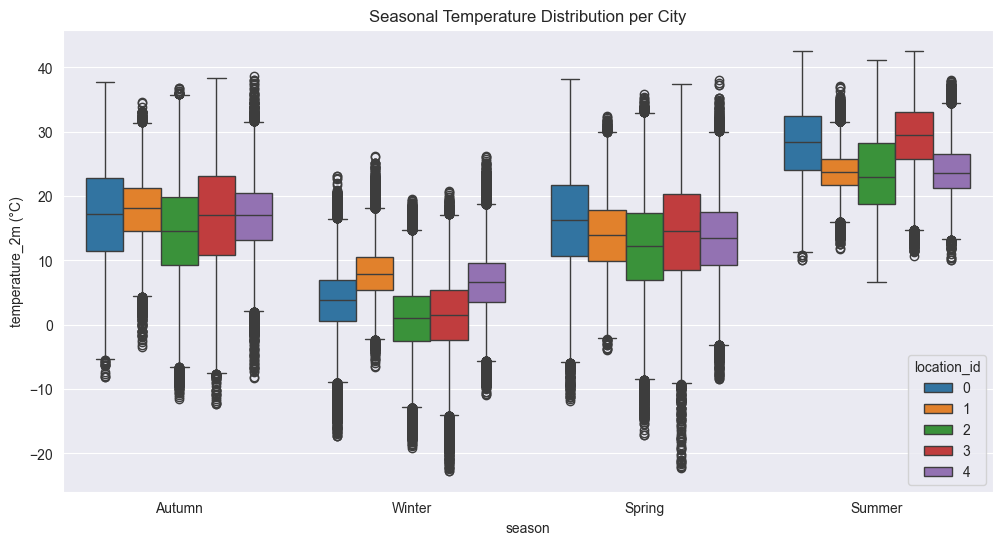

In [27]:
#seasonly boxplot

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="season", y="temperature_2m (°C)", hue="location_id")
plt.title("Seasonal Temperature Distribution per City")
plt.show()

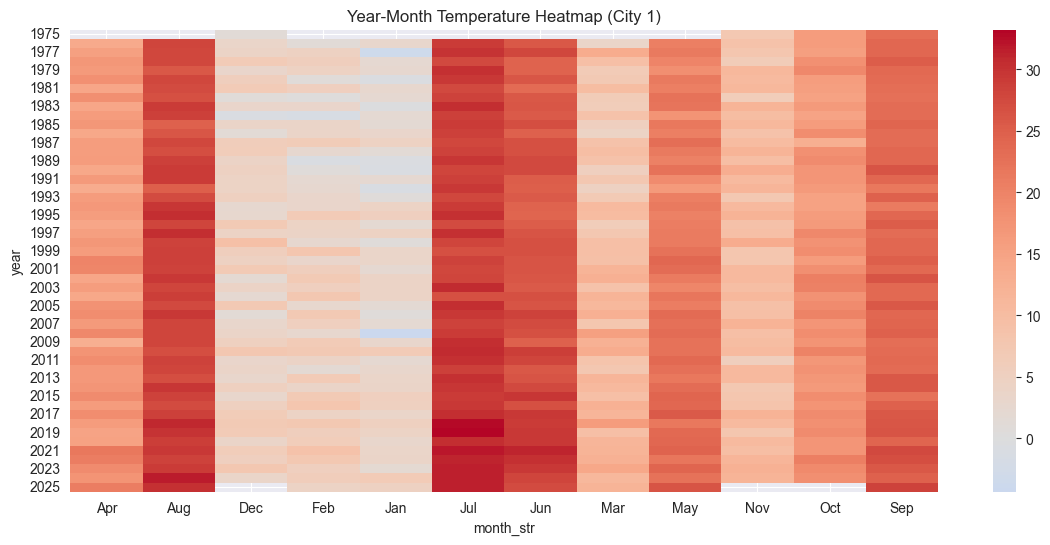

In [29]:
#yearly heatmap for on city for example

df["month_str"] = df["time"].dt.strftime("%b")
monthly_city = df[df["location_id"]==df["location_id"].unique()[0]].groupby(["year","month_str"])["temperature_2m (°C)"].mean().unstack()

plt.figure(figsize=(14,6))
sns.heatmap(monthly_city, cmap="coolwarm", center=0)
plt.title("Year-Month Temperature Heatmap (City 1)")
plt.show()
